In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

import nltk
from nltk.stem.porter import PorterStemmer
from wordcloud import WordCloud

from langdetect import detect_langs
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.metrics import accuracy_score

import warnings
warnings.filterwarnings("ignore")

## Data Acquire

In [2]:
df=pd.read_csv('restaurant.csv', encoding='latin-1')

In [3]:
df.head()

,Unnamed: 0,review_id,user_id,business_id,stars,useful,funny,cool,text,date
0,2370338,_WTGv5XnA-qb_XD1D7Z0jg,6PgdGb3HrZdsfl2GiULo8w,RESDUcs7fIiihp38-d6_6g,5,0,1,0,After getting food poisoning at the Palms hote...,2012-12-04 03:10:18
1,2370357,JlNnsvMPLK_1-X2hwzK24w,IS9yw8P2uAPBX6FNLLX4KA,RESDUcs7fIiihp38-d6_6g,4,39,21,29,"""A feast worthy of Gods""\n\nBaccarnal Buffet i...",2014-01-17 00:50:50
2,2370373,hBkoWffORRb6aqKhC_Li2A,uZdFsE_aHbFBChgN6Xa8tw,RESDUcs7fIiihp38-d6_6g,4,1,1,1,The crab legs are better than the ones at Wick...,2015-06-08 18:03:09
3,2370411,rbkxvrgZg5kdCL2a66QYmA,8ZWJNAEWsymXDzKx3B0tTQ,RESDUcs7fIiihp38-d6_6g,1,0,0,0,Not worth it! Too salty food and expensive! Th...,2016-12-19 16:15:29
4,2370500,5tw_pedoHVi9bgeiBNsISg,E0sm4Ve7ifanFYeQMcV8Eg,RESDUcs7fIiihp38-d6_6g,5,0,0,0,I would give this infinite stars if I could. M...,2015-07-28 07:13:17


In [4]:
df=df[['stars','text','date']]

In [5]:
df.sample(10)

,stars,text,date
607,4,A very good Las Vegas buffet. I have been wan...,2015-04-29 16:03:00
4696,5,Came on a Thursday night around 8:00 pm. Prob...,2014-06-08 21:22:51
4340,5,Definitely the best buffet in Las Vegas. Quali...,2015-02-23 07:13:23
4947,3,Giving both the Wicked Spoon and Bacchanal on...,2014-11-19 05:08:44
8776,1,"Not worth it! Long wait, rude receptionist, ol...",2019-02-12 01:20:35
7370,3,7/31/2018. \nArrive: 1:45PM\nPay: 2:10PM\nSeat...,2018-08-03 03:53:03
2420,1,After 90 minutes wait on Saturday afternoon fo...,2014-05-13 19:18:17
347,4,"The food was good, but not exceptional, probab...",2017-05-26 04:35:27
8674,1,We stop by on Sunday 7/28/2019 for dinner. The...,2019-07-29 02:11:12
7122,4,"Eh, felt really crowed and the route to get th...",2015-12-04 05:31:54


## Exploratory Data Analysis

In [6]:
df.columns=["Stars", "Text", "Date"]

<Axes: xlabel='Stars', ylabel='count'>

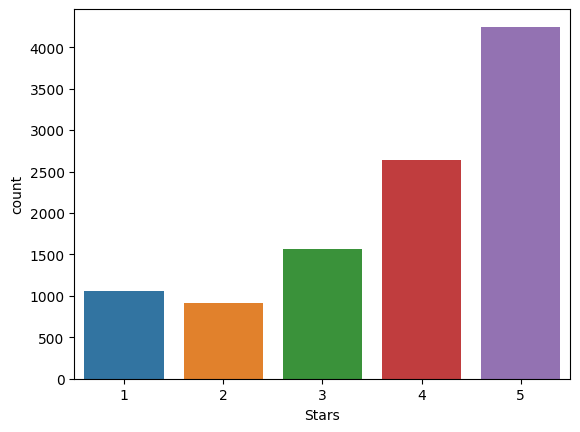

In [7]:
sns.countplot(x=df["Stars"])

In [8]:
df.Stars.value_counts().sort_values(ascending=False)

Stars
5    4247
4    2636
3    1561
1    1056
2     917
Name: count, dtype: int64

In [9]:
df['Text'].value_counts()

Text
On our last day in Vegas, we decided to have our final lunch here and oh boy we made the BEST DECISION ever.\n\nThe food and its quality is simply outstanding! From the hot plated breakfast to the mouth watering gelato desserts. The pork buns and dimsums were a family favorite. The roast beef etc were hot! Everything was phenomenal. \n\nStaff were very attentive too. Nice and courteous. \n\nThese are the reasons this is the BEST BUFFET IN VEGAS. \n\nWhen we come back in Vegas, expect us to be back!!!                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          

In [10]:
df.duplicated().sum()

0

## Text Processing

In [27]:
df['Text']=df['Text'].str.lower()
df['Text']=df['Text'].str.replace('[^\w\s]','') #noktalama isaretklerini kaldir
df['Text']=df['Text'].str.replace('\d+','') #Rakamlari kaldir
df['Text']=df['Text'].str.replace('\n','').replace('\r','') #satirlari ve enter islemlerini kaldir

In [28]:
df

,Stars,Text,Date,Sentiment,Language
0,5,after getting food poisoning at the palms hote...,2012-12-04 03:10:18,positive,en
1,4,"""a feast worthy of gods""baccarnal buffet in ca...",2014-01-17 00:50:50,positive,en
2,4,the crab legs are better than the ones at wick...,2015-06-08 18:03:09,positive,en
3,1,not worth it! too salty food and expensive! th...,2016-12-19 16:15:29,negative,en
4,5,i would give this infinite stars if i could. m...,2015-07-28 07:13:17,positive,en
...,...,...,...,...,...
10364,5,"best buffet ever! irma was great, served us be...",2019-11-17 20:39:36,positive,en
10365,4,hollllllyyyy moleyyyy! this buffet was one for...,2019-11-12 02:23:07,positive,en
10366,5,the selection is amazing and all the food is e...,2019-12-12 03:27:22,positive,en
10367,4,one of the best buffets i've had in vegas. my ...,2019-11-01 21:00:51,positive,en


In [14]:
df.Text[0]

"after getting food poisoning at the palms hotel, i was scared to eat at any more buffets. but we figured with the high price tag, the positive reviews etc, it was worth a chance. i'm really glad we gave it a try. (btw i uploaded a collage of the things we ate)the seafood line is by the far the longest, i would not recommend showing up in heels if you're female, my feet were killing me between the line at the door, the line to get sat, and the seafood line. totally worth it though.the prime rib was the best ive ever had.i loved the sweet potato tots.i even have pho!the music was great and so was our server alma, ( he was a older gentleman with a mustache and was very attentive and delightful).i will return next trip in more comfortable shoes. after a horrible visit at the palms with non stop issues in a matter of 48 hours, your establishment was truly the high light of our trip. thank you for an exquisite dinner."

In [15]:
df.loc[df['Stars']==3,"Sentiment"]="neutral"
df.loc[df['Stars']<3,"Sentiment"]="negative"
df.loc[df['Stars']>3,"Sentiment"]="positive"

<Axes: xlabel='Sentiment', ylabel='count'>

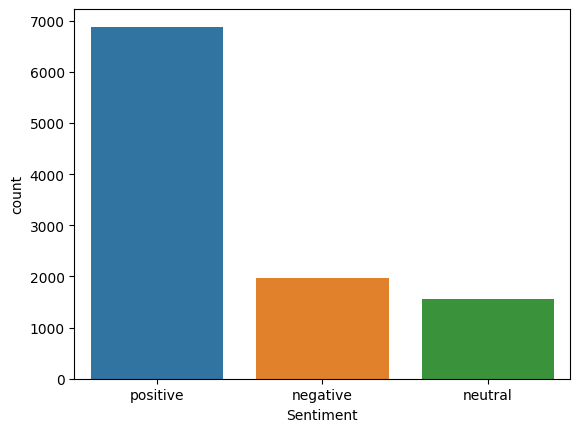

In [16]:
sns.countplot(x=df['Sentiment'])

In [17]:
# Language Detection
language = [detect_langs(i) for i in df.Text]
languages = [str(i[0]).split(':')[0] for i in language]
df['Language'] = languages

In [18]:
df['Language'].value_counts()

Language
en    10369
da       11
es       10
pt        9
sv        6
fr        6
de        4
sw        1
sk        1
Name: count, dtype: int64

In [19]:
df=df[df['Language']=='en']
df.reset_index(drop=True,inplace=True)

In [20]:
df

,Stars,Text,Date,Sentiment,Language
0,5,after getting food poisoning at the palms hote...,2012-12-04 03:10:18,positive,en
1,4,"""a feast worthy of gods""baccarnal buffet in ca...",2014-01-17 00:50:50,positive,en
2,4,the crab legs are better than the ones at wick...,2015-06-08 18:03:09,positive,en
3,1,not worth it! too salty food and expensive! th...,2016-12-19 16:15:29,negative,en
4,5,i would give this infinite stars if i could. m...,2015-07-28 07:13:17,positive,en
...,...,...,...,...,...
10364,5,"best buffet ever! irma was great, served us be...",2019-11-17 20:39:36,positive,en
10365,4,hollllllyyyy moleyyyy! this buffet was one for...,2019-11-12 02:23:07,positive,en
10366,5,the selection is amazing and all the food is e...,2019-12-12 03:27:22,positive,en
10367,4,one of the best buffets i've had in vegas. my ...,2019-11-01 21:00:51,positive,en


## Vectorizer & Modeling

In [21]:
x=df["Text"]
y=df["Sentiment"]

In [22]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

In [23]:
x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)

In [24]:
#vect=CountVectorizer(stop_words="english")

vect=CountVectorizer()
#x=vect.fit_transform(x)
#mb=MultinomialNB()

In [ ]:
#mb=MultinomialNB()
#mb.fit(x_train,y_train)
#guess=mb.predict(x_test)

In [ ]:
#accuracy_score(y_test, guess)

In [29]:
def classification_funct(vect,x,y):
    from sklearn.naive_bayes import GaussianNB
    from sklearn.naive_bayes import BernoulliNB
    from sklearn.svm import SVC
    from sklearn.neighbors import KNeighborsClassifier
    from sklearn.tree import DecisionTreeClassifier
    from sklearn.ensemble import RandomForestClassifier
    from sklearn.linear_model import LogisticRegression
    from xgboost import XGBClassifier
    
    from sklearn.metrics import accuracy_score,precision_score,recall_score,f1_score
    from sklearn.metrics import confusion_matrix,classification_report
    
    x_train,x_test,y_train,y_test=train_test_split(x,y,test_size=0.2,random_state=42)
    
    print(x_train.shape,x_test.shape,y_train.shape,y_test.shape)
    
    g=GaussianNB()
    b=BernoulliNB()
    SVC=SVC()
    KN=KNeighborsClassifier()
    D=DecisionTreeClassifier()
    R=RandomForestClassifier()
    Log=LogisticRegression()
    XGBC=XGBClassifier()
    
    #algos=[g,b,SVC,KN,D,R,Log,XGBC]
    #algo_names=['GaussianNB','BernoulliNB','SVC','KNeighborsClassifier',
    #            'DecisionTreeClassifier','RandomForestClassifier','LogisticRegression','XGBClassifier']
    
    algos=[g,b,SVC,KN]
    algo_names=['GaussianNB','BernoulliNB','SVC','KNeighborsClassifier']
    
    
    accuracy_scored=[]    
        
    x_train_dtm=vect.fit_transform(x_train).toarray()
    x_test_dtm=vect.transform(x_test).toarray()
    
    for item in algos:
        item.fit(x_train_dtm,y_train)
        accuracy_scored.append(accuracy_score(y_test,item.predict(x_test_dtm)))
    result=pd.DataFrame(accuracy_scored,columns=['accuracy_score'],index=algo_names)
    result.accuracy_score=accuracy_scored
    return result.sort_values('accuracy_score',ascending=False)  

In [30]:
vect=CountVectorizer()
classification_funct(vect,x,y)

(8295,) (2074,) (8295,) (2074,)


,accuracy_score
SVC,0.781099
BernoulliNB,0.688042
KNeighborsClassifier,0.673578
GaussianNB,0.414176


In [31]:
def wc(data,bgcolor):
    from PIL import Image
    mask = np.array(Image.open("cloud.png"))
    wc=WordCloud(background_color=bgcolor, width=800, height=400,mask=mask,max_words=100).generate(' '.join(data))
    plt.figure( figsize=(20,10) )
    plt.imshow(wc)
    plt.axis('off')
    plt.show()

In [35]:
negative_words=df[df['Sentiment']=="negative"]['Text']
positive_words=df[df['Sentiment']=="positive"]['Text']
neutral_words=df[df['Sentiment']=="neutral"]['Text']

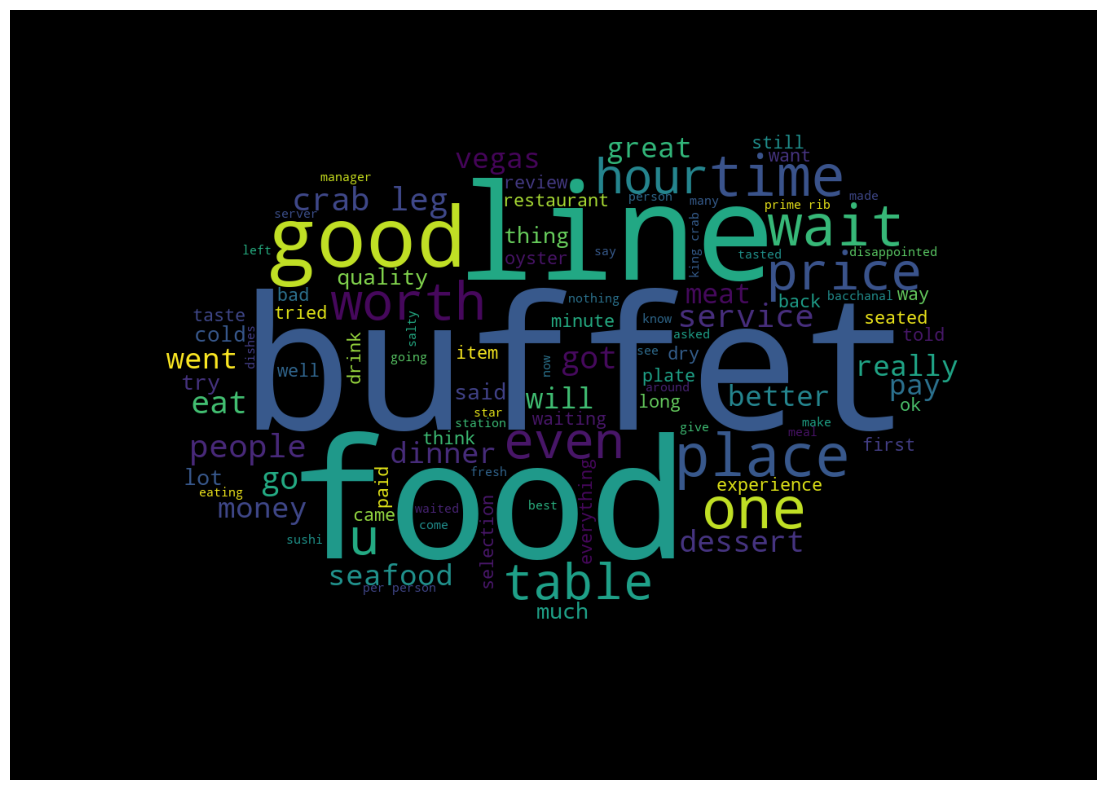

In [36]:
wc(negative_words,'black')

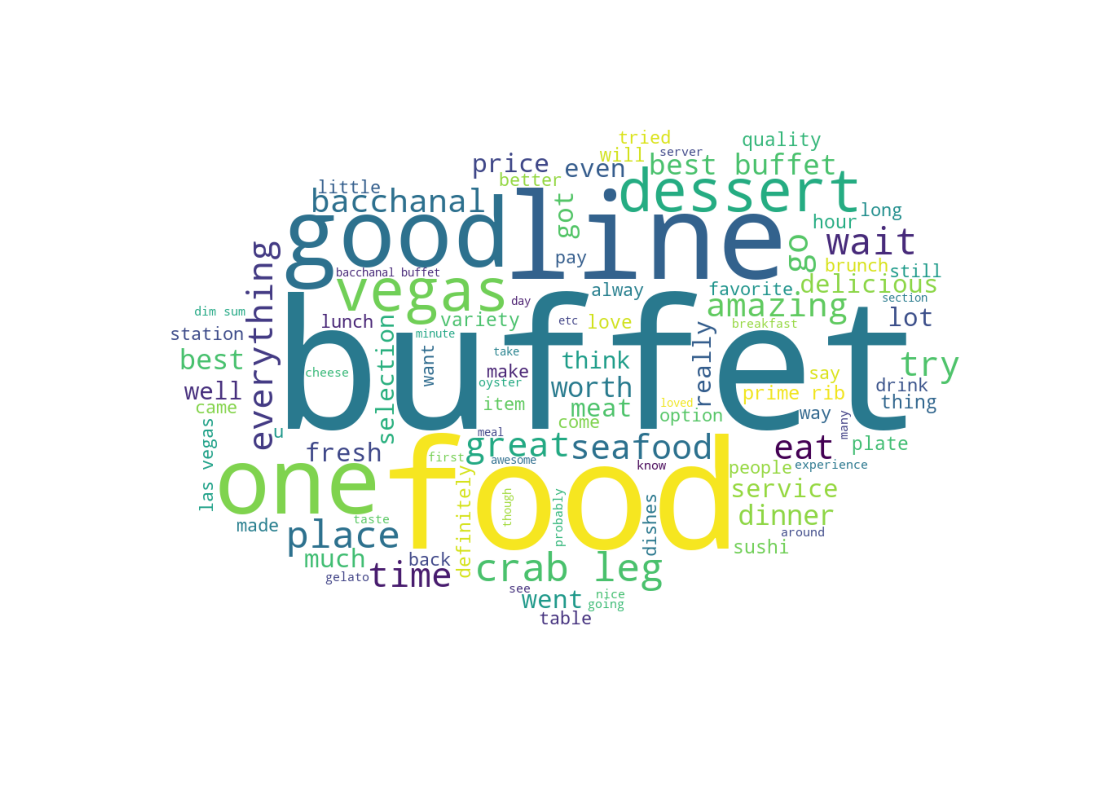

In [37]:
wc(positive_data,'white')

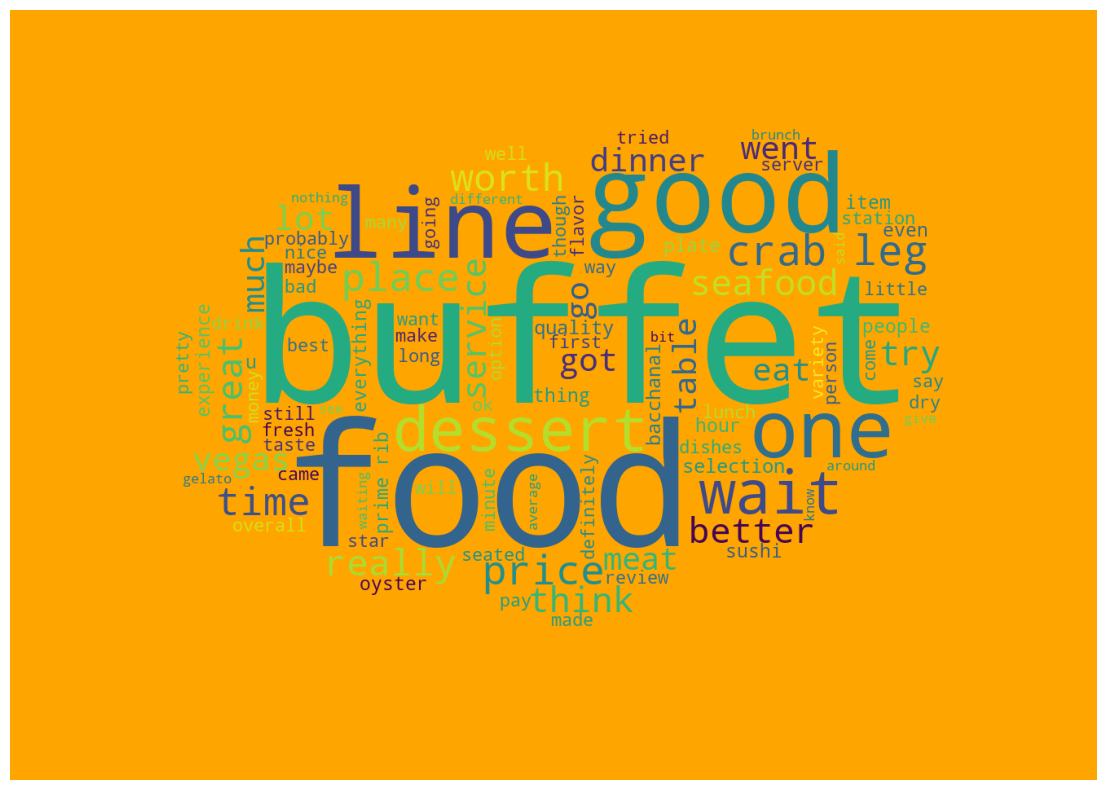

In [38]:
wc(neutral_data,'orange')

In [57]:
sentence=negative_words[3]

In [58]:
TextBlob(sentence).sentiment

Sentiment(polarity=-0.484375, subjectivity=0.39999999999999997)